In [1]:
import os
from typing import Literal

from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import display, Image

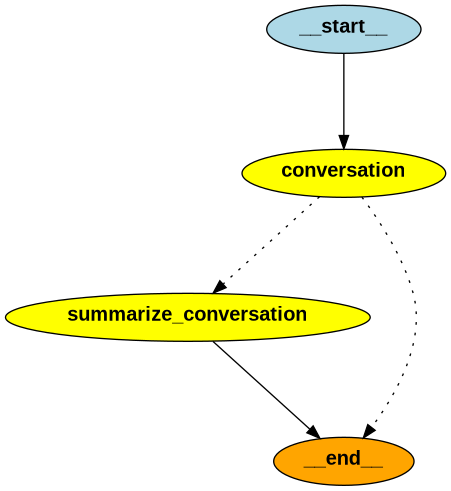

In [3]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)


class State(MessagesState):
    summary: str


def call_model(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = SystemMessage(content=f"Summary of conversation earlier: {summary}")
        messages = [system_message] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}


def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = HumanMessage(content=(
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        ))
    else:
        summary_message = HumanMessage(content="Create a summary of the conversation above:")

    messages = state["messages"] + [summary_message]
    response = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END


workflow = StateGraph(State)

workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_png()))

In [3]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': [AIMessage(content='Hi Lance! 👋 How’s it going? What’s on your mind today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 11, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BrMbOL6maMdCRDP1rO8Po1IaRzfxq', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4c39a519-dcde-47ee-913e-6a0ad49a465b-0', usage_metadata={'input_tokens': 11, 'output_tokens': 18, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [5]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"][0].pretty_print()

================================== Ai Message ==================================

Hi Lance! 😊 It seems like you're excited to introduce yourself—nice to meet you! What's up?


In [6]:
config = {"configurable": {"thread_id": "2"}}

input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! 👋 How’s it going? What’s on your mind today?
---------------------------------------------------------------------------


In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [8]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run--488dfa16-102a-4a05-8e87-47f5337fd7e0')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, resp

In [9]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| one| of| the| most| stor|ied| franchises| in| the| National| Football| League| (|NFL|).| Known| for| their| rich| history|,| iconic| players|,| and| championship| success|,| the| |49|ers| have| been| a| cornerstone| of| professional| football| since| their| founding|.

|###| **|Team| Overview|**
|-| **|Founded|:**| |194|6|
|-| **|Location|:**| Santa| Clara|,| California| (|Le|vi|'s| Stadium|)
|-| **|Team| Colors|:**| Red|,| Gold|,| White|
|-| **|Masc|ot|:**| S|ourd|ough| Sam|
|-| **|Division|:**| NFC| West|
|-| **|Ownership|:**| Jed| York| (|CEO| of| the| |49|ers|,| representing| the| York| family|)

|###| **|History|**
|The| |49|ers| were| established| in| |194|6| as| part| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |195|0| after| the| AA|FC| merged| with| the| league|.| The| team| is| named| after| the| prospect|ors| who| flock|ed| to| California| during| the| |184|9| Gold| Rush|.

|###| **|Champ|ionship| Su